# BME-230B Spring 2019 HW 2 Question 
Andrew Davidson aedavids@ucsc.edu

supposedly it took Andrew and Yianni 3 days to write the louvain clustering algo. The inner loop is about 100 lines.

Given we only get 10 pts for the implementation and we are running out of time lets use the scanpy version for now

## <span style="color:red">TODO</span>
    - implement 2.a Louvain Clustering 
    
## <span style="color:red">2.c AEDWIP TODO</span>
- hypergeometric distribution ???
- our talble shows all cell types we should select max
    * use head to show what we got after group by    

- ref
    * [scanpy.tl.umap](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.tl.umap.html)
    * [scanpy.api.pp.neighbors](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.api.pp.neighbors.html?highlight=neighbors)
    * [scanpy.pl.umap](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.pl.umap.html#scanpy.pl.umap)
    * [scanpy.tl.louvain](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.tl.louvain.html#scanpy.tl.louvain)
    * [GSEAPY: Gene Set Enrichment Analysis in Python. pypi.org](https://pypi.org/project/gseapy/)
    * [GSEAPY: Gene Set Enrichment Analysis in Python gseapy.readthedocs.io](https://gseapy.readthedocs.io/en/latest/introduction.html)
    * [anndata](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html)
        + "uns" stands for unstructured data
        + "obs" are panda data frame observations 
        + "obsm key-indexed multi-dimensional observations

In [1]:
from euclid_knn import knnG
import gseapy
import matplotlib.pyplot as plt
import numpy as np

# import random
# random.seed(43)

import pandas as pd
import scanpy.api as sc
import scanpy
print("scanpy.__version__:{}".format(scanpy.__version__))

scanpy.__version__:1.4.1


## 2.b. [5 pts] 
Turn in a UMAP plot of the combined dataset as you did in question #1, but
this time, color the cells by their Louvain cluster assignments determined for each cell
within each batch as a different color in each plot.

In [2]:
%%time
anndata = sc.read("PBMC.merged.h5ad")
knnG(anndata, n_neighbors=12)

emptying .uns...
CPU times: user 2min 24s, sys: 1.85 s, total: 2min 26s
Wall time: 2min 20s


In [3]:
%%time
# resolution : float, None
# For the default flavor ('vtraag'), you can provide a resolution 
# (higher resolution means finding more and smaller clusters), 
# which defaults to 1.0. See “Time as a resolution parameter” in [Lambiotte09].
scanpy.tl.louvain(anndata, resolution=1)

CPU times: user 2.27 s, sys: 54 ms, total: 2.32 s
Wall time: 1.77 s


In [4]:
plt.figure(figsize=(10,10))
scanpy.tl.umap(anndata)

<Figure size 720x720 with 0 Axes>

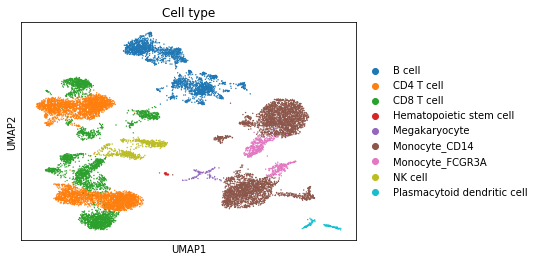

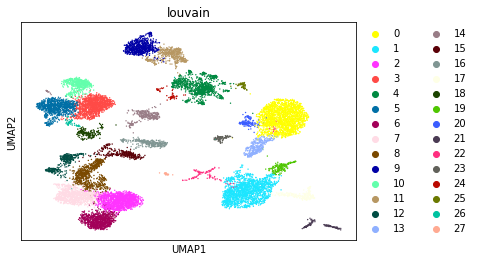

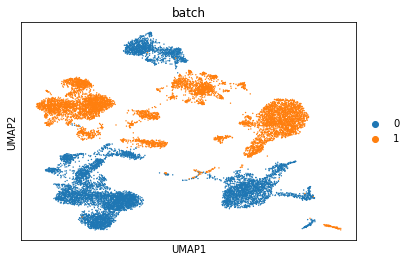

In [5]:
scanpy.pl.umap(anndata, color=['Cell type'])
scanpy.pl.umap(anndata, color=["louvain"])
scanpy.pl.umap(anndata, color=["batch"])

## <span style="color:red">AEDWIP TODO</span>
this is what we talked about in our team meeting on 5/10. It does not work. Notice the graphs are idential

- after louvain split into  sets 3prime and 5prime
- create two plots batch vs cell type

prime3Rows.sum(): 8098
prime5Rows.shape: 7378


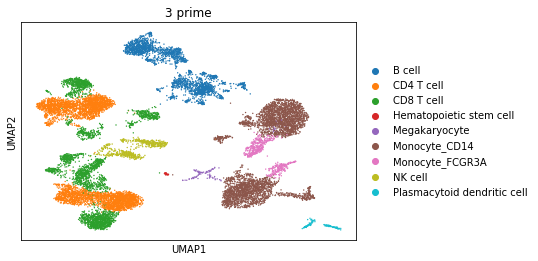

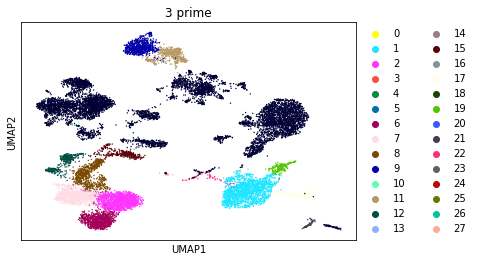

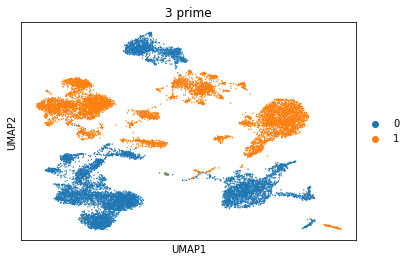

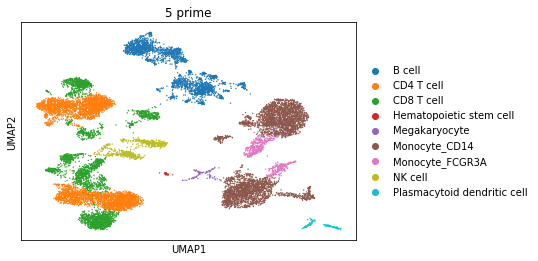

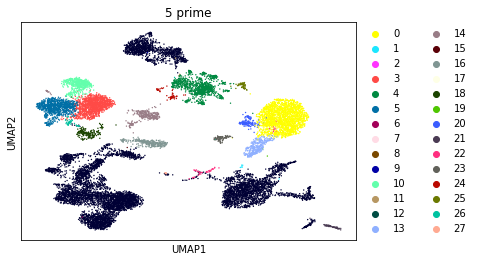

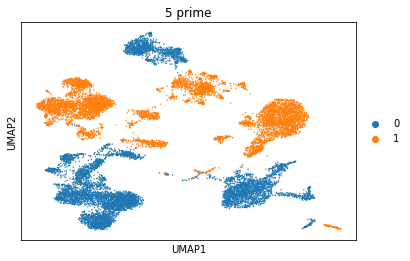

In [6]:
prime3Rows = anndata.obs['Method'] == '10X_3prime'
prime5Rows = anndata.obs['Method'] == '10X_5prime'
print("prime3Rows.sum(): {}".format(prime3Rows.sum()))
print("prime5Rows.shape: {}".format(prime5Rows.sum()))

# save output created by running louvain on combined data set
louvainClusters =  anndata.obs.loc[:,['louvain']]
# print(type(louvainClusters))
# louvainClusters.head()

# selec the 3prime cells and blot
prime3Cluster = louvainClusters.loc[prime3Rows,:]
# prime3Cluster.head()
anndata.obs.loc[:,['louvain']] = prime3Cluster
scanpy.pl.umap(anndata, color=['Cell type'], title="3 prime")
scanpy.pl.umap(anndata, color=["louvain"], title="3 prime")
scanpy.pl.umap(anndata, color=["batch"], title="3 prime")

# selec the 3prime cells and blot
prime5Cluster = louvainClusters.loc[prime5Rows,:]
anndata.obs.loc[:,['louvain']] = prime5Cluster
scanpy.pl.umap(anndata, color=['Cell type'], title="5 prime")
scanpy.pl.umap(anndata, color=['louvain'], title="5 prime")
scanpy.pl.umap(anndata, color=['batch'], title="5 prime")


# this create three subpots in a row
# scanpy.pl.umap(anndata, color=['Cell type', 'louvain', 'batch'])

## 2.c. [5 pts] 
Turn in a table that lists each cluster and its best-matching cell type
annotation. The table should contain the cluster number and its best matching cell-type
annotation based on the hypergeometric analysis.

In [7]:
#anndata.obs['louvain'].head(3)

In [8]:
#anndata.obs.loc[:,['louvain', 'Cell type']].head()

In [9]:
df = anndata.obs.loc[:,['louvain', 'Cell type']]
df.head()

,louvain,Cell type
index,,
data_3p-AAACCTGAGCATCATC-0,NaN,B cell
data_3p-AAACCTGAGCTAGTGG-0,NaN,CD4 T cell
data_3p-AAACCTGCACATTAGC-0,NaN,CD4 T cell
data_3p-AAACCTGCACTGTTAG-0,NaN,Monocyte_CD14
data_3p-AAACCTGCATAGTAAG-0,NaN,Monocyte_CD14


In [10]:
grouped = df.groupby(['louvain', 'Cell type'])
# grouped.describe()
grouped['louvain'].count()

louvain  Cell type                  
0        B cell                            1
         Megakaryocyte                     4
         Monocyte_CD14                  1919
         Monocyte_FCGR3A                  17
1        Monocyte_CD14                     6
3        CD4 T cell                     1223
         CD8 T cell                       14
4        B cell                         1029
         Monocyte_CD14                     2
5        CD4 T cell                      939
         CD8 T cell                        2
6        CD8 T cell                        1
9        B cell                            1
10       CD4 T cell                        4
         CD8 T cell                      507
11       B cell                            3
13       Monocyte_CD14                     4
         Monocyte_FCGR3A                 335
14       B cell                            1
         CD4 T cell                        2
         CD8 T cell                      309
15       NK cell  

## <span style="color:red">2.c AEDWIP TODO</span>
- hypergeometric distribution ???
- our talble shows all cell types we should select max
    * use head to show what we got after group by

## 2.d. [5 pts] 
Turn in a list of top 5 pathways for each cluster in each dataset. You should
use the gene expression signature of each cluster to find an associated pathway. A gene
signature for a cluster represents the gene expression levels for a characteristic cell that is a
member of the cluster. Use the centroid 𝞵 i of the i th cluster as the signature. Compute the
centroids for each cluster in each dataset. You will next derive a gene-signature based
annotation for each cluster using these centroids. Use a list of Gene Ontology Biological
Process categories (provided in the Resources section at the top of this homework) and your
signatures to perform an all-against-all Gene Set Enrichment Analysis (GSEA). Turn in a table
that lists the top 5 pathways for each cluster

hello world

1. create a data frame we can use to select the cells in a given cluster
    a. we need the index value we can use to to get the cell's expression
    values from the numpy array anndata.obsm['X_pca'].shape

In [11]:
numCells = anndata.obs['louvain'].size
numCells

numpyArrayIdx = [i for i in range(numCells)]
d = {'louvain':anndata.obs['louvain'], 'npIdx':numpyArrayIdx }
louvainDF = pd.DataFrame(data=d)
louvainDF.head()

,louvain,npIdx
index,,
data_3p-AAACCTGAGCATCATC-0,NaN,0
data_3p-AAACCTGAGCTAGTGG-0,NaN,1
data_3p-AAACCTGCACATTAGC-0,NaN,2
data_3p-AAACCTGCACTGTTAG-0,NaN,3
data_3p-AAACCTGCATAGTAAG-0,NaN,4


In [12]:
cluster9Cells = louvainDF['louvain'] == '9'
cluster9Cells.head()

index
data_3p-AAACCTGAGCATCATC-0    False
data_3p-AAACCTGAGCTAGTGG-0    False
data_3p-AAACCTGCACATTAGC-0    False
data_3p-AAACCTGCACTGTTAG-0    False
data_3p-AAACCTGCATAGTAAG-0    False
Name: louvain, dtype: bool

In [13]:
louvainDF.loc[cluster9Cells, :].count()

louvain    1
npIdx      1
dtype: int64

In [14]:
louvainDF.loc[cluster9Cells, :].head()

,louvain,npIdx
index,,
data_5p-AGATCTGAGTCTCAAC-1,9,9055


In [15]:
louvainDF.loc[cluster9Cells, ['npIdx']].head()

,npIdx
index,
data_5p-AGATCTGAGTCTCAAC-1,9055


In [16]:
def getCellsIdxForCluster(anndata, clusterId):
    '''
    returns a list of indices that can be use to select the cells in 
    the cluster. the indices are int values that correspond to the
    rows in the numpy array anndata.obsm['X_pca']
    
    assumes clustering algorithym was run and results stored in
    anndata.obs['louvain']
    
    arguments:
        anndata
        clusterId: a string
    '''
    numCells = anndata.obs['louvain'].size

    numpyArrayIdx = [i for i in range(numCells)]
    d = {'louvain':anndata.obs['louvain'], 'npIdx':numpyArrayIdx }
    louvainDF = pd.DataFrame(data=d)
    
    clusterCells = louvainDF['louvain'] == clusterId
    ret = louvainDF.loc[cluster9Cells, ['npIdx']]
    return ret.values.flatten()
    
def testGetCellsIdxForCluster(anndata):
    ret = getCellsIdxForCluster(anndata,clusterId=9)
    print("AEDWIP len(ret):{}".format(len(ret)))
    # print("AEDWIP type(ret):{}".format(type(ret)))
    # print ("AEDWIP ret:\n{}".format(ret))
    # count varies slightly from kernal restart to kernal restart
    # sending random.seed() or using , random_state=42 argument to
    # scanpy.louvain() did not resolve this issue
    # assert 747 == len(ret)
    
testGetCellsIdxForCluster(anndata)

AEDWIP len(ret):1


In [17]:
# cellIndices = getCellsIdxForCluster(anndata,clusterId=9)
# print(type(cellIndices))
# print(cellIndices.shape)
# print(type(anndata.obsm['X_pca']))
# print(anndata.obsm['X_pca'].shape)
# print(anndata.obsm['X_pca'][cellIndices].shape)
# anndata.obsm['X_pca'][cellIndices]

In [18]:
def getGeneExpressionSignatureForCluster(anndata, clusterId):
    '''
    returns the centroid for cluster
    
    assumes:
        1) gene expression values stored in anndata.X
        
        2) clustering algorithym was run and results stored in
            anndata.obs['louvain']
    
    arguments:
        anndata
        clusterId: a string
    '''
    cellIndices = getCellsIdxForCluster(anndata ,clusterId)
    # pathways are in gene space not pca(50) space
    # anndata.obsm is a pandas data frame
    # data = anndata.obsm['X_pca'][cellIndices]
    # anndata.X is numpy array
    data = anndata.X[cellIndices, :]

    byColumns = 0
    return np.mean(data, axis=byColumns)

def testGetGeneExpressionSignatureForCluster(anndata):
    ret = getGeneExpressionSignatureForCluster(anndata, clusterId='9')
    # PCA 50
    #expFirst = np.array([-5.547451, 13.029236, -0.9483415, 
    #                    -5.8531246, -2.0250516])
    #expLast = np.array([-0.05719902, -0.16065401, 0.14730875, 
    #                    0.00936914, -0.06920523])
    
    # anndata.XC
    print("ret[0:5]:\n{}".format(ret[0:5]))
    print("ret[-5:]:\n{}".format(ret[-5:]))

    # count varies slightly from kernal restart to kernal restart
    # sending random.seed() or using , random_state=42 argument to
    # scanpy.louvain() did not resolve this issue
#     np.testing.assert_array_almost_equal(expFirst, ret[0:5])
#     np.testing.assert_array_almost_equal(expLast, ret[-5:])
    
testGetGeneExpressionSignatureForCluster(anndata)

ret[0:5]:
[-0.1964075  -0.56439495 -0.18641369 -0.2225193  -0.13066347]
ret[-5:]:
[-0.06438084 -0.18611676 -0.0779918   0.8760074  -0.77732456]


In [19]:
# print( pd.unique(louvainDF.loc[:, ['louvain']]) )
print( pd.unique(louvainDF['louvain']) )
clusterSigs = {}
for clusterId in pd.unique(louvainDF['louvain']) :
    sig = getGeneExpressionSignatureForCluster(anndata, clusterId)
    clusterSigs[clusterId] = sig

#clusterSigs['3']

[NaN, 16, 0, 14, 4, ..., 9, 19, 17, 15, 6]
Length: 25
Categories (24, object): [16, 0, 14, 4, ..., 19, 17, 15, 6]
